In [1]:
%matplotlib inline
import matplotlib.cm as cm
from matplotlib.colors import Normalize   
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter, FuncFormatter
import matplotlib.transforms
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
# sns.set(font_scale=0.2)

In [2]:
# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 10}

# from matplotlib import rc
# from matplotlib import rcParams
# rc('font', **font)

In [3]:
table_path = Path('/Users/aavattikutis/Documents/epidemicmodel/cccruns/fits/fit13/tables/')
# table_path = Path('/Users/aavattikutis/Documents/epidemicmodel/cccruns/fits/tables-fit14/')
product_path = Path('../../results')

In [4]:
# Fix region names, remove underscore
def fix_region_name(roi):
    roi = roi.replace('_', ' ')
    roi = ' '.join(roi.split(',')[::-1]).strip()
    return roi

# EDIT THIS --> PUT FIT TABLE PATH<br>
Get list of regions to average over for global

In [5]:
df = pd.read_csv(table_path / 'fit_table_reweighted.csv')
df['roi'] = df['roi'].apply(fix_region_name)

rois = list(df.roi.unique())

rois.remove('US')
rois.remove('AA Global')
## discard these if outliers
# rois.remove('France')
# rois.remove('Russia')
# rois.remove('Malaysia')
# rois.remove('Honduras')
# rois.remove('Senegal')
# rois.remove('Algeria')


# EDIT THIS --> change to the correct date name for latest week in data

In [6]:
# Add column for May 7th
#REPLACE May 7th WITH DATE FOR LATEST WEEK

def add_latestwk(df, stats):
    for stat in stats:
        df['%s (May 17th)' % stat] = df.filter(regex=("%s \(w.*" % stat)).apply(lambda x: x.dropna().get(-1, None), axis=1)
    return df

def add_firstwk(df, stats):
    for stat in stats:
        df['%s (week 0)' % stat] = df.filter(regex=("%s \(w.*" % stat)).apply(lambda x: x.dropna().get(0, None), axis=1)
    return df

df = add_latestwk(df, ['Rt', 'car', 'ifr'])
df = add_firstwk(df, ['Rt', 'car', 'ifr'])


In [7]:
df = df.set_index(['roi', 'quantile']).sort_index()

In [8]:
# def get_global(df):
#     # Compute global stats
#     df = df.drop('AA Global', errors='ignore')
#     df.columns.name = 'param'
#     means = df.unstack('roi').loc['mean'].unstack('param')
#     weights = (1/df.unstack('roi').loc['std']**2).fillna(0).unstack('param')
#     global_mean = (means*weights).sum() / weights.sum()
#     global_sd = ((weights*((means - global_mean)**2)).sum()/weights.sum())**(1/2)
#     df.loc[('GLOBAL', 'mean'), :] = global_mean
#     df.loc[('GLOBAL', 'std'), :] = global_sd
#     for quantile in ['0.025', '0.25', '0.5', '0.75', '0.975']:
#         vals = df.unstack('roi').loc[quantile].unstack('param')
#         df.loc[('GLOBAL', quantile), :] = (vals*weights).sum() / weights.sum()
#     #df = df.sort_index()
#     #gl = df.loc['Global']
#     return df

### not certain but above function 
### had a miscount between number of elements vs number expected based on rois

###REPLACE MAY 7TH WITH DATE FROM ABOVE 

theta_ = ["R0","car (week 0)", "ifr (week 0)","Rt (May 17th)",
          "car (May 17th)", "ifr (May 17th)"]

def get_global2(theta):
    g_ = {}
    for q in q_:
        v = []
        w = []
        for roi in rois:
            v.append(df.loc[(roi,q),theta])
            w.append(1/(df.loc[(roi,'std'),theta]**2))
            if np.isnan(w[-1]):
                del(v[-1],w[-1])
        v = np.array(v)
        w = np.array(w)
        g = sum(v*w)/sum(w)
        df.loc[('GLOBAL', q),theta] = g
        g_[q] = g
    return g_

def afun1(x):
    return '%s' % float('%.1g' %x)

def afun2(x):
    return '%s' % float('%.2g' %x)


q_ = ['0.025','0.25','0.5','0.75','0.975']

for theta in theta_:
    g_ = get_global2(theta)
    if theta[0]=='R':
        print(theta+' median: '+str(afun2(g_['0.5']))+' CI: ('+
          ','.join([str(afun2(g_['0.025'])),str(afun2(g_['0.975']))])+')\n')
    else:
        print(theta+' median: '+str(afun1(g_['0.5']))+' CI: ('+
          ','.join([str(afun1(g_['0.025'])),str(afun1(g_['0.975']))])+')\n')
    

R0 median: 2.2 CI: (1.6,3.5)

car (week 0) median: 0.002 CI: (0.0005,0.007)

ifr (week 0) median: 1e-05 CI: (3e-06,7e-05)

Rt (week 17) median: 0.003 CI: (0.0028,0.004)

car (week 17) median: 0.004 CI: (0.001,0.01)

ifr (week 17) median: 5e-05 CI: (1e-05,0.0002)



In [9]:
# Restrict ROIs for some analyses

dfo = pd.read_csv(table_path / 'fit_table_reweighted.csv')
dfo['roi'] = dfo['roi'].apply(fix_region_name)

rois = list(dfo.roi.unique())

roi_us = np.sort([i for i in rois if i[:2]=='US'])
# roi_other = np.sort([i for i in rois if i[:2]!='US'])
top25 = pd.read_csv(product_path / "top25.csv", index_col=0, header=None).index
top25 = top25.map(fix_region_name)
roi_other = sorted(list(top25) + ['China','Australia','Canada'])#,'Senegal','Malaysia','Honduras','Algeria'])
rois = ['GLOBAL']+ list(roi_other) + list(roi_us)  
rois.remove('US')
# rois.remove('AA Global')

df_top = df.loc[rois]
print("There are %d regions under consideration" % len(rois))

There are 83 regions under consideration


### Figure 2-4

In [10]:
def clean_df(df, stat):
    result = df[stat].unstack('quantile')
    return result

def box_vs_roi(df, stat, labl, sort=True, low=0.12, high=22, palette=None, ax=None, subtract=None):
    sns.set(rc={'ytick.left': True, 'xtick.bottom': True})
    if ax is None:
        fig = plt.figure(figsize=(15, 5))
    else:
        fig = plt.gcf()
    clean = clean_df(df, stat)
    clean = clean.iloc[:, :5] # Only quantiles
    if sort is True:
        clean = clean.sort_values('0.5', ascending=False)
    elif sort is not False:
        clean = clean.loc[sort]
    clean = clean.loc[['GLOBAL'] + list(clean.index.drop('GLOBAL'))]
    if subtract:
        clean2 = clean_df(df, subtract)
        clean2 = clean2.loc[clean.index]
        clean2 = clean2.iloc[:, :5] # Only quantiles
        diffs = np.log10(clean['0.5'] / clean2['0.5'])
#         diffs = (clean['0.5'] - clean2['0.5'])#np.log10(clean2['0.5'] / clean['0.5'])
        cmap = cm.seismic #cm.RdBu_r
        norm = Normalize(vmin=-1, vmax=1)
        palette = [cmap(norm(diff)) for diff in diffs]
    else:
        palette = None
    ax = sns.boxplot(data=clean.T, whis=99, ax=ax, palette=palette)
    for i, box in enumerate(ax.artists):
        box.set_edgecolor('black')
        if palette is None:
            box.set_facecolor('white')
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels, rotation=70, fontsize=10);
    ax.set_yscale('log')
    if True:#'R' in stat:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x,_: "%d"%x if x>=1 else '%.1g'%x))
        ax.yaxis.set_minor_formatter(FuncFormatter(lambda x,_: "%d"%x if x in [2, 5] else ''))
    dx = 8/72.; dy = 0/72. 
    ax.margins(x=0.01, y=0.01)
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')
        label.set_transform(label.get_transform() + offset)
    ax.set_xlim(-1, len(clean))
    ax.set_ylim(low, high)
    ax.set_xlabel('')
    ax.set_ylabel(labl, fontsize=18);
    return list(clean.index)

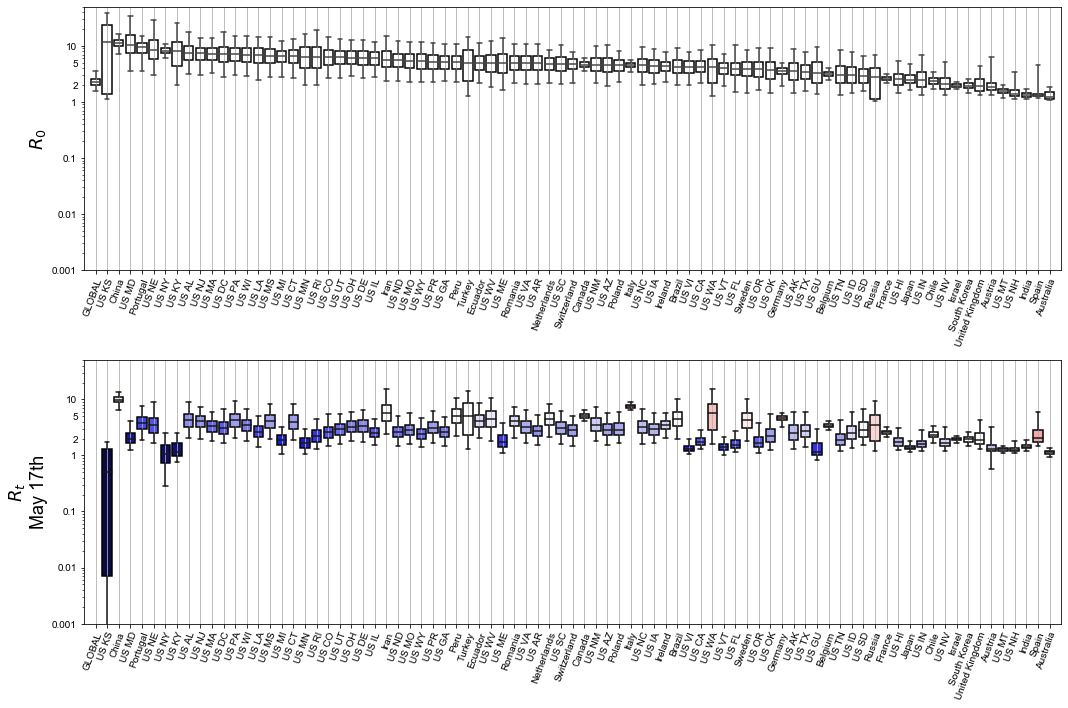

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
rois = box_vs_roi(df_top, 'R0', '$R_0$', ax=ax[0], low=1e-3, high=0.5e2);
ax[0].xaxis.grid(True)
box_vs_roi(df_top, 'Rt (May 17th)', '$R_t$\nMay 17th', low=1e-3, high=0.5e2, ax=ax[1], subtract='R0', sort=rois);
ax[1].xaxis.grid(True)

plt.tight_layout()

plt.savefig(product_path / 'Fig2_Rt.png', dpi=400)

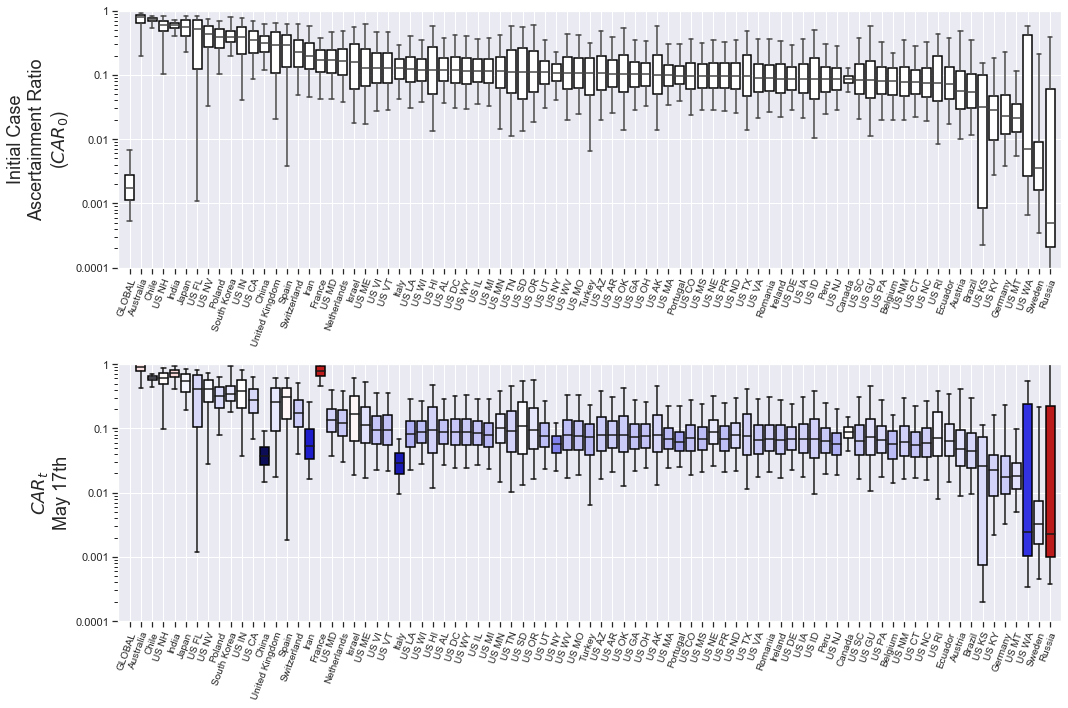

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
rois = box_vs_roi(df_top, 'car (week 0)', 'Initial Case\nAscertainment Ratio\n($CAR_0$)', 
                  ax=ax[0], low=1e-4, high=1,);
ax[0].xaxis.grid(True)

box_vs_roi(df_top, 'car (May 17th)', '$CAR_t$\nMay 17th', low=1e-4, high=1, 
           ax=ax[1], subtract='car (week 0)', sort=rois);
ax[1].xaxis.grid(True)
plt.tight_layout()
plt.savefig(product_path / 'Fig4_cart.png', dpi=400)

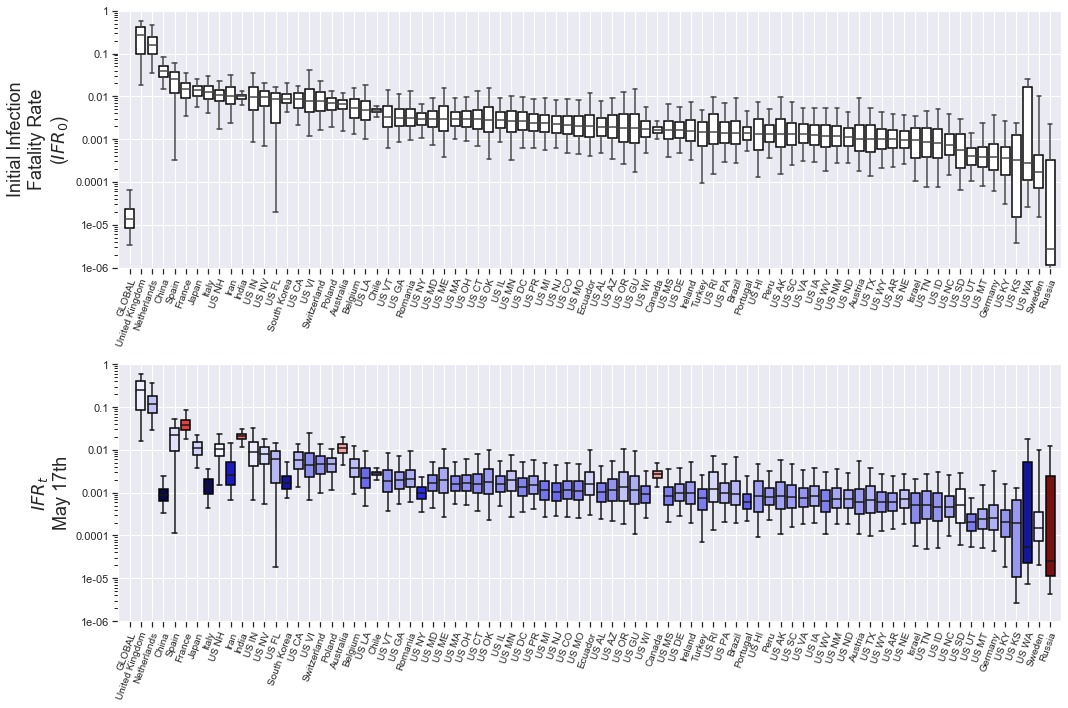

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
rois = box_vs_roi(df_top, 'ifr (week 0)', 'Initial Infection\nFatality Rate\n($IFR_0$)', 
                  ax=ax[0], low=1e-6, high=1);
ax[0].xaxis.grid(True)

box_vs_roi(df_top, 'ifr (May 17th)', '$IFR_t$\nMay 17th', low=1e-6, high=1, 
           ax=ax[1], subtract='ifr (week 0)', sort=rois);
ax[1].xaxis.grid(True)

plt.tight_layout()
plt.savefig(product_path / 'Fig5_ifrt.png', dpi=400)

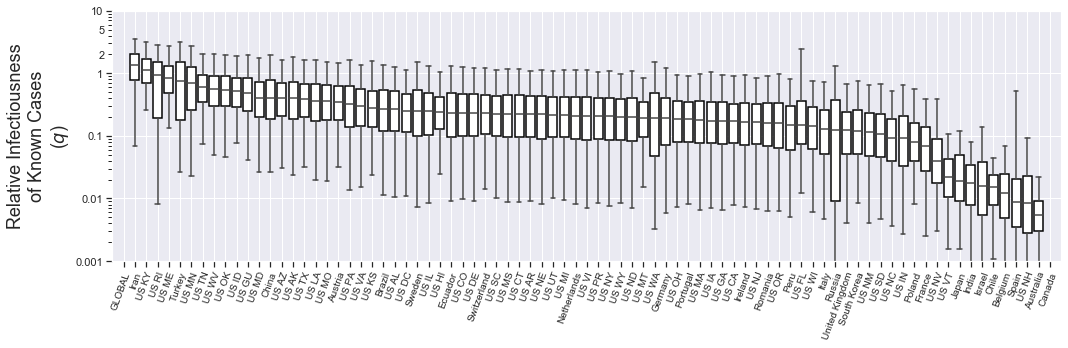

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
rois = box_vs_roi(df_top, 'q', 'Relative Infectiousness\nof Known Cases\n($q$)', ax=ax, low=1e-3, high=1e1);
plt.tight_layout()
ax.xaxis.grid(True)

plt.tight_layout()
plt.savefig(product_path / 'Fig_q.png', dpi=400)

### Herd immunity, etc

In [15]:
# sns.set(style='dark', font_scale=1.2, rc={'ytick.left': True, 'ytick.right': False})
# quantiles = ['0.025', '0.25', '0.5', '0.75', '0.975']
# fig, axes = plt.subplots(3, 1, figsize=(6, 10), sharex=True)
# for i, pair in enumerate([('R0', 'Rt (May 7th)'), ('car (week 0)', 'car (May 7th)'), ('ifr (week 0)', 'ifr (May 7th)')]):
#     ax = axes.flat[i]
#     sns.boxplot(data=gl.loc[quantiles, pair], whis=99, ax=ax)
#     ax.set_xlabel('');
#     ax.set_yscale('log')
# #axes.flat[0].set_yticks(range(9))
# axes.flat[0].set_xticklabels(['Initial', 'May 7th'])
# axes.flat[0].set_ylabel('$R_t$')
# axes.flat[1].set_ylabel('$CAR_t$')
# axes.flat[2].set_ylabel('$IFR_t$')

# xticks = [1, 3, 10]
# ax = axes.flat[0]
# ax.set_yticks(xticks)
# ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
# axt = ax.twinx()
# axt.set_yscale('log')
# axt.set_ylim(*ax.get_ylim())
# axt.minorticks_off()
# axt.set_yticks([1.02, 1.25, 1.5, 2, 3, 5, 10])
# axt.set_yticklabels(['%.2g' % (1 - 1/x) for x in axt.get_yticks()])
# axt.set_ylabel('Herd Immunity Threshold')

# xticks = [0.1, 1]
# ax = axes.flat[1]
# ax.set_yticks(xticks)
# ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
# axt = ax.twinx()
# axt.set_yscale('log')
# axt.set_ylim(*ax.get_ylim())
# axt.minorticks_off()
# axt.set_yticks([1/21, 1/11, 1/6, 1/4, 1/2])
# axt.set_yticklabels(['%d' % (1/x - 1) for x in axt.get_yticks()])
# axt.set_ylabel('# of unreported infections\nfor each reported case')


# xticks = [0.001, 0.01, 0.1]
# ax = axes.flat[2]
# ax.set_yticks(xticks)
# ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
# axt = ax.twinx()
# axt.set_yscale('log')
# axt.set_ylim(*ax.get_ylim())
# axt.minorticks_off()
# axt.set_yticks([1/1001, 1/501, 1/201, 1/101, 1/51, 1/21, 1/11])
# axt.set_yticklabels(['%d' % (1/x - 1) for x in axt.get_yticks()])
# axt.set_ylabel('# of total infections\nper case death')

# plt.tight_layout()

In [16]:
# # Figure 6
# sns.set(style='dark', font_scale=1.5)
# ax = sns.boxplot(data=gl.loc[quantiles, ['q']], whis=99)
# ax.set_yscale('log')
# yticks = [0.003, 0.01, 0.03, 0.1, 0.3, 1]
# ax.set_yticks(yticks)
# ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
# ax.set_ylabel('Infectiousness of known\ninfectedrelative to\nunknown infected ($q$)')
# ax.set_xticklabels(['Global Average'])
# ax.set_xlabel('')
# axt = ax.twinx()
# axt.set_yscale('log')
# axt.set_ylim(*ax.get_ylim())
# axt.minorticks_off()
# axt.set_yticks(yticks)
# axt.set_yticklabels(['%d' % (1/x) for x in axt.get_yticks()])
# axt.set_ylabel('Fold reduction\nin infectiousness');

In [17]:
#import sys
#sys.path.insert(0, '/home/rgerkin/covid-sicr/Stan')
#from __init__ import reweighted_stats
#reweighted_stats('/home/rgerkin/covid-sicr/fits/fit_table_raw.csv')

In [18]:
# # Model comparison
# import pandas as pd

# df = df_raw.set_index(['quantile'])
# df = df[df['roi'] != 'Gambia']
# #df = df[df['roi'].str.contains('US_')]
# df = df.loc['0.5'][['model', 'roi', 'waic', 'loo']].set_index('roi')#reset_index()
# fig, ax = plt.subplots(1, 2, figsize=(15,5), sharey=True)
# #sns.violinplot(data=df, x='model', y='waic')
# #sns.set(font_scale=1.5)
# for i, kind in enumerate(['waic', 'loo']):
#     sns.stripplot(data=df, y='model', x=kind, ax=ax[i], orient='h', alpha=0.5,
#                   order=['nonlinearmodel', 'nonlinearmodelq0ctime', 'fulllinearmodel',
#                          'reducedlinearmodelNegBinom', 'reducedlinearmodelq0', 'reducedlinearmodelq0ctime'])
#     #ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=80);
#     ax[i].set_xscale('log')
#     ax[i].set_ylabel('')
# plt.tight_layout()

### The End

In [19]:
# def stat_vs_stat(df, stat1, stat2):
#     sns.set(font_scale=1.5, rc={'xtick.bottom': True, 'ytick.left': True, 'xtick.top': True, 'ytick.right': True})
#     fig = plt.figure(figsize=(10, 10))
#     clean1 = clean_df(df, stat1)
#     clean2 = clean_df(df, stat2)
#     plt.errorbar(clean1['0.5'], clean2['0.5'],
#                  xerr=clean1['std'], yerr=clean2['std'],
#                  color='b', marker='o', ls='none', alpha=0.5)
#     plt.xscale('log')
#     plt.yscale('log')
#     import matplotlib.transforms
#     dx = 7/72.; dy = 0/72. 
#     #ax.margins(x=0.01, y=0.01)
#     offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
#     for label in plt.gca().get_xticklabels():
#         label.set_horizontalalignment('right')
#         label.set_transform(label.get_transform() + offset)
#     low = 0.08
#     high = 15
#     plt.plot([low, high], [low, high], 'k--')
#     plt.xlim(0.8, 15)
#     plt.ylim(0.12, 15)
#     plt.xlabel('$R_0$\n(first cases in region)');
#     plt.ylabel('$R_t$\n(May 7th, 2020)');
    
#stat_vs_stat(df, 'R0', 'Rt (May 7th)');